## Pipeline
## ----------
## Must be run before running any other piece of code in this notebook

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import time
import numpy.ma as ma
import sys

sys.path.append('/home/vibin/MyFolder/WorkDesk/DP2/Codes/Clustering_analysis_PS1_and_shen')
from Clustering_module import *

def p_corr_fun(r, r0, delta, r_min, r_max):
    #A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    return pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

def get_r_from_prob(r0, delta, r_min, r_max):
    c = np.random.uniform(0, 1, 1)[0]
    A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(r_min, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)

def make_clust_dist(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def make_clust_dist_v3(num, r0, delta, box_size, r_min, r_max, start_cond = None):
    if start_cond == 'center':
        dat_array = np.array([box_size/2, box_size/2, box_size/2]).reshape((3,1))
    else:
        dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            new_pt = np.reshape(dat_array[:,-1], (3,1))
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def quadrant(vel, box_size):
    if vel >= 0:
        return box_size
    else : 
        return 0

quadrant = np.vectorize(quadrant)

def make_clust_dist_v2(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
#------------------------------------------------------------------------------------------------------
            old_pt = dat_array[:,-1]

            vel = new_pt.flatten() - old_pt
            rem_dist = quadrant(vel, box_size) - old_pt
            print(vel, rem_dist)

            time_taken = np.min(rem_dist/vel)
            new_pt = np.reshape(vel * time_taken, (3,1))
#------------------------------------------------------------------------------------------------------
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins):
    
    bin_avg = np.array((bins[:-1] + bins[1:])/2)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    RR_count = results[:,3]/2
    #plt.stairs(RR_count, bins)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
    results = np.array(list(map(list, results)))
    DD_count = results[:,3]/2
    #plt.stairs(DD_count, bins)

    results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    DR_count = results[:,3]
    #plt.stairs(DR_count, bins)

    DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
    RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
    DR_norm = len(x_dat) * len(x_ran)

    xi = ma.masked_values(DD_count * RR_count * DR_count, 0)
    xi[~xi.mask]= (DD_count[~xi.mask]/DD_norm - 2 * DR_count[~xi.mask]/DR_norm + RR_count[~xi.mask]/RR_norm)/ (RR_count[~xi.mask]/RR_norm)


    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(bin_avg, xi, '.', label=r"$\xi$ of the simulation")
    if len(bin_avg[xi.mask]) != 0 :
        ax.plot(bin_avg[xi.mask], np.zeros_like(bin_avg[xi.mask]), 'r.', label="bins with any of the counts zero")
    ax.axhline(0)
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\xi(r)$')

    ax.legend()
    return ax

## Simulation of clustered data in 3d box

Text(0.5, 0.92, 'Distribution of the unclustered points in a box')

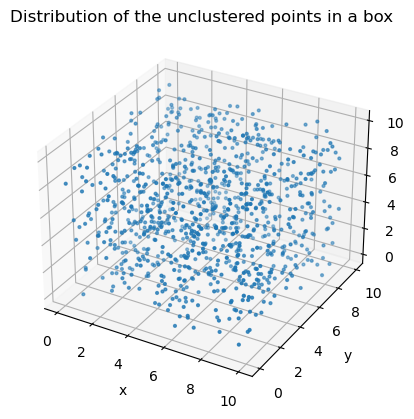

In [2]:
x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3,1000))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_ran, y_ran, z_ran, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of the unclustered points in a box")

Text(0.5, 0, 'r')

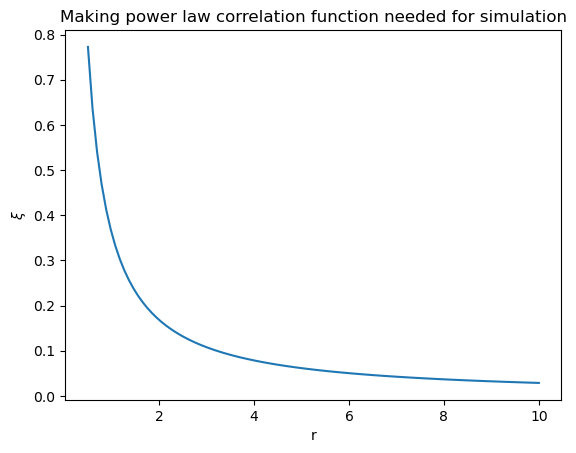

In [14]:
def p_corr_fun(r, r0, delta):
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    return A * pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

r_vals = np.linspace(0.5, 10, 100)
xi_vals = xi_r(r_vals, 1.0, 1.1)

plt.plot(r_vals, xi_vals)
plt.title("Making power law correlation function needed for simulation")
plt.ylabel(r"$\xi$")
plt.xlabel("r")

Text(0, 0.5, 'Number count')

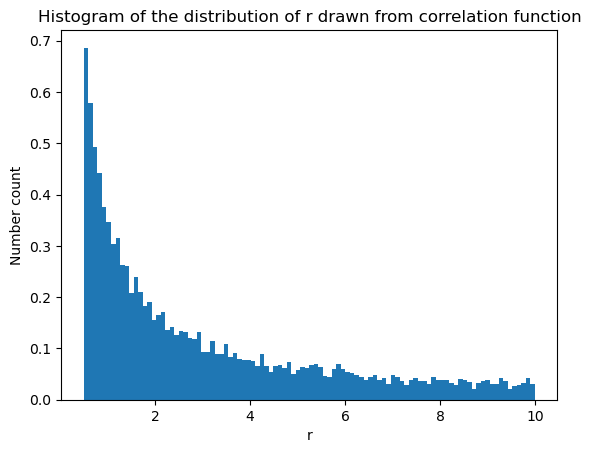

In [15]:
def get_r_from_prob(c, r0, delta):
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(0.5, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)
ran_01 = np.random.uniform(0, 1, 10000)

r_rans = get_r_from_prob_vec(ran_01, 1.0, 1.1)
plt.hist(r_rans, 100, density=True);
plt.title("Histogram of the distribution of r drawn from correlation function")
plt.xlabel("r")
plt.ylabel("Number count")

In [4]:
def make_clust_dist(num, r0, delta):
    dat_array = np.random.uniform(0, 10, (3, 1))

    for i in range(num - 1):
        c = np.random.uniform(0, 1, 1)[0]
        r = get_r_from_prob(c, r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[10], [10], [10]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)

    return dat_array

Text(0.5, 0.92, 'Distribution of clustered points following power law')

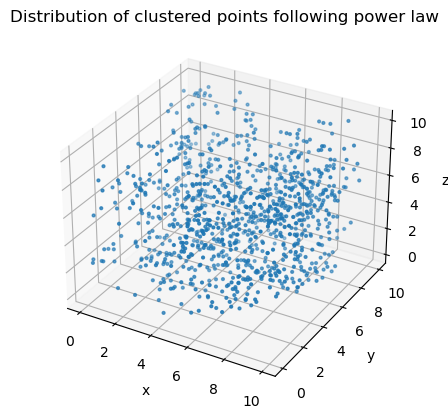

In [16]:
x, y, z = make_clust_dist(1000, 1.0, 1.1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")

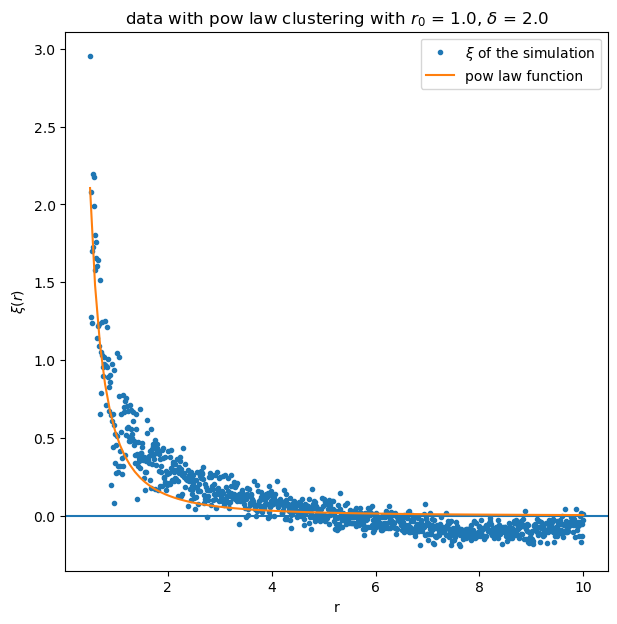

In [17]:
r0 = 1.0
delta = 2.0

x_dat, y_dat, z_dat = make_clust_dist(1000, r0, delta)
x_ran, y_ran, z_ran = np.random.uniform(0, 10, (3, 10000))

bins = np.linspace(0.5, 10, 1000)
bin_avg = (bins[:-1] + bins[1:])/2

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
results = np.array(list(map(list, results)))
RR_count = results[:,3]/2
#plt.stairs(RR_count, bins)

results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
results = np.array(list(map(list, results)))
DD_count = results[:,3]/2
#plt.stairs(DD_count, bins)

results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
results = np.array(list(map(list, results)))
DR_count = results[:,3]
#plt.stairs(DR_count, bins)

DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
DR_norm = len(x_dat) * len(x_ran)

xi = (DD_count/DD_norm - 2 * DR_count/DR_norm + RR_count/RR_norm)/ (RR_count/RR_norm)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(bin_avg, xi, '.', label=r"$\xi$ of the simulation")
ax.axhline(0)
ax.set_xlabel('r')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}".format(r0, delta))

r_vals = np.linspace(0.5, 10, 100)
xi_vals = xi_r(r_vals, r0, delta)

ax.plot(r_vals, xi_vals, label="pow law function")
ax.legend()

#### Note: A systematic error is observed in the measured correlation function of clustered data

## Analysis of simulation of clustered data in 3d box under various conditions

In [2]:
def Look_into(x_dat, y_dat, z_dat, r0, delta, n_d, n_r, bins, box_size, r_min, r_max):
    start = time.time()


    x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))

    ax = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax

In [11]:
r0 = 1.0
delta = 2.0
r_min = 0.5
r_max = 10
n_d = 1000
box_size = 10

x_dat, y_dat, z_dat = make_clust_dist_v3(n_d, r0, delta, box_size, r_min, r_max)

Text(0.5, 0.92, 'Distribution of clustered points following power law')

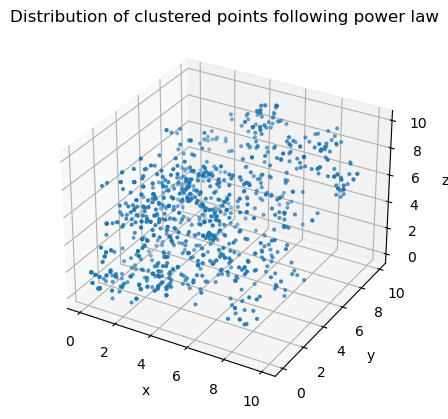

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_dat, y_dat, z_dat, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")

Total time take = 19.01 s


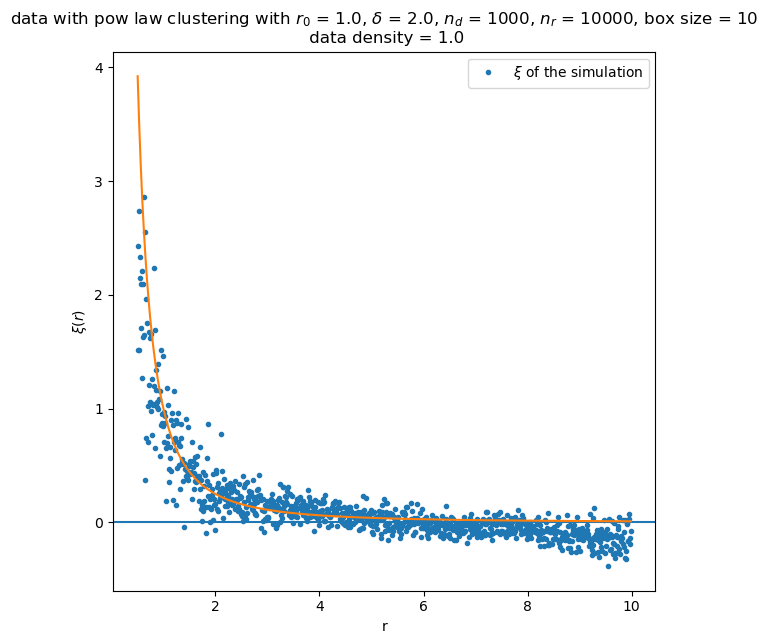

In [12]:
n_r = 10000
bin_start = 0.5   
bin_end = 10
bin_width = 0.01

bins = np.arange(0.5, bin_end, bin_width)
ax = Look_into(x_dat, y_dat, z_dat, r0 = r0, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max)

Total time take = 19.22 s


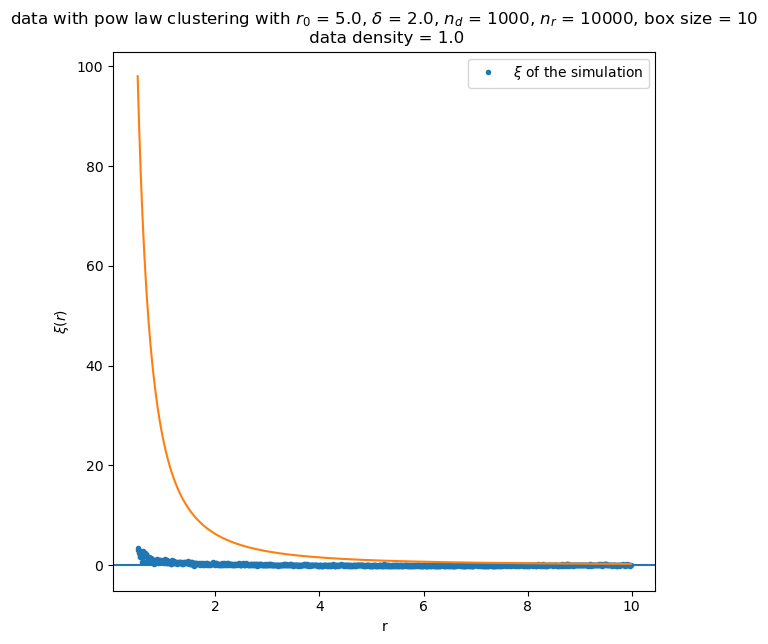

In [29]:
r0 = 5.0
delta = 2.0
r_min = 0.5
r_max = 10
n_d = 1000
box_size = 10

x_dat2, y_dat2, z_dat2 = make_clust_dist_v3(n_d, r0, delta, box_size, r_min, r_max, start_cond = 'center')


n_r = 10000
bin_start = 0.5   
bin_end = 10
bin_width = 0.01

bins = np.arange(0.5, bin_end, bin_width)
ax = Look_into(x_dat2, y_dat2, z_dat2, r0 = r0, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max)

## Simulating in a shell

In [21]:
global low_r, up_r
low_r = 7
up_r = 10

def make_rand_dist_shell(num):
    z = np.random.uniform(-1, 1, num)
    phi = np.random.uniform(0, 2*np.pi, num)
    theta = np.arccos(z)

    r = np.random.uniform(low_r, up_r, num)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def spher_to_cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return x, y, z

def make_clust_dist_shell(num, r0, delta):
    r = np.random.uniform(low_r, up_r)
    phi = np.random.uniform(0, 2 * np.pi, 1)[0]
    z = np.random.uniform(-r, r, 1)[0]
    theta = np.arccos(z/r)
    dat_array = np.array(spher_to_cart(r, theta, phi)).reshape(3,1)
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.sum(pow(new_pt, 2)) < low_r | np.sum(pow(new_pt, 2)) > up_r:
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

Text(0.5, 0.92, 'Distribution of the unclustered points in a box')

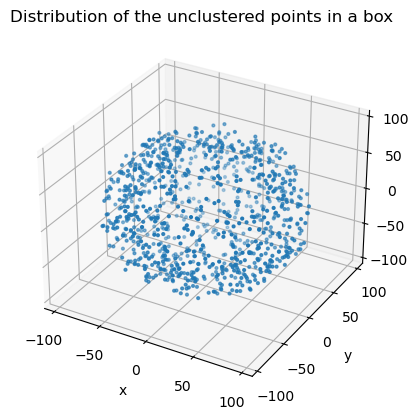

In [47]:
x_ran, y_ran, z_ran = make_rand_dist_shell(1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_ran, y_ran, z_ran, s=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of the unclustered points in a box")

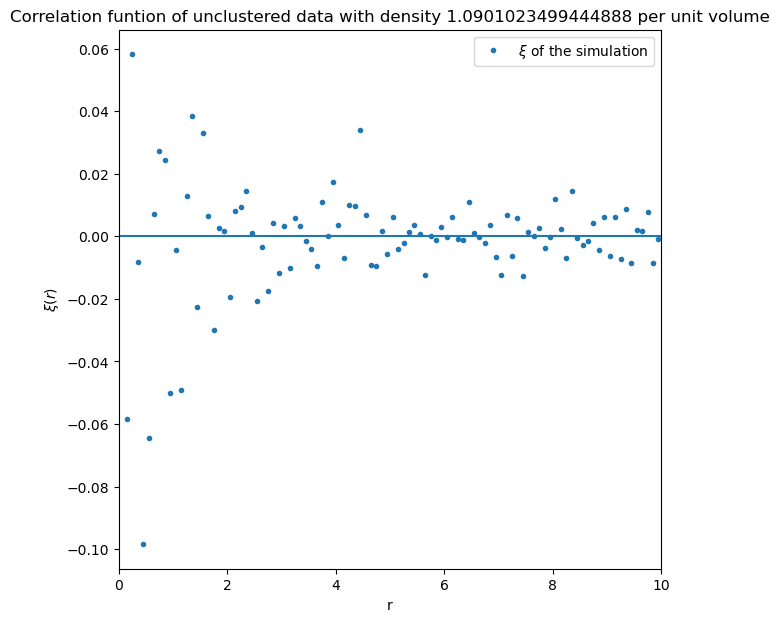

In [42]:
n_d = 3000
n_r = 30000
x_ran1, y_ran1, z_ran1 = make_rand_dist_shell(n_d)
x_ran, y_ran, z_ran = make_rand_dist_shell(n_r)

bins = np.linspace(0.1, 10, 100)
ax = calc_corr_fun(x_ran1, y_ran1, z_ran1, x_ran, y_ran, z_ran, bins)
vol = (4/3)*np.pi * (up_r ** 3 - low_r ** 3)
ax.set_title("Correlation funtion of unclustered data with density {} per unit volume".format(n_d/vol))
ax.set_xlim(0, 10);

## Simulating in ps1 footprint

In [50]:
global low_r, up_r
low_r = 50
up_r = 60
r_min = 10
r_max = 15

def add_spher_coords(array1, array2):
    r1, theta1, phi1 = array1
    r2, theta2, phi2 = array2

    x = r1 * np.cos(theta1) * np.cos(phi1) + r2 * np.cos(theta2) * np.cos(phi2)
    y = r1 * np.cos(theta1) * np.sin(phi1) + r2 * np.cos(theta2) * np.sin(phi2)
    z = r1 * np.sin(theta1) + r2 * np.sin(theta2)

    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arcsin(z/r)
    if y >= 0:
        phi = np.arccos(x/np.sqrt(x**2 + y**2))
    else:
        phi = 2 * np.pi - np.arccos(x/np.sqrt(x**2 + y**2))

    return np.array([r, theta, phi])

def make_clust_dist_ps1(num, r0, delta):
    while True:
        r = np.random.uniform(low_r, up_r)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-0.5 * r, r, 1)[0]
        theta = np.arcsin(z/r)

        if (np.absolute(np.arcsin(np.cos(theta) * np.cos(np.radians(27.4)) * np.cos(phi - np.radians(192.25)) \
                                            + np.sin(theta) * np.sin(np.radians(27.4)))) > np.radians(20)) :
            break

    dat_array = np.array([r ,theta, phi]).reshape(3,1)
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arcsin(z/r)
        
        new_pt = add_spher_coords(dat_array[:,-1], np.array([r, theta, phi])).reshape(3,1)
        
        if (np.absolute(np.arcsin(np.cos(new_pt[1]) * np.cos(np.radians(27.4)) * np.cos(new_pt[2] - np.radians(192.25)) \
                                            + np.sin(new_pt[1]) * np.sin(np.radians(27.4)))) < np.radians(20)) | (new_pt[1] < (- np.pi/6)) | (new_pt[0] < low_r) | (new_pt[0] > up_r):
            continue

        dat_array = np.append(dat_array, new_pt, axis = 1)
        i += 1

    return dat_array

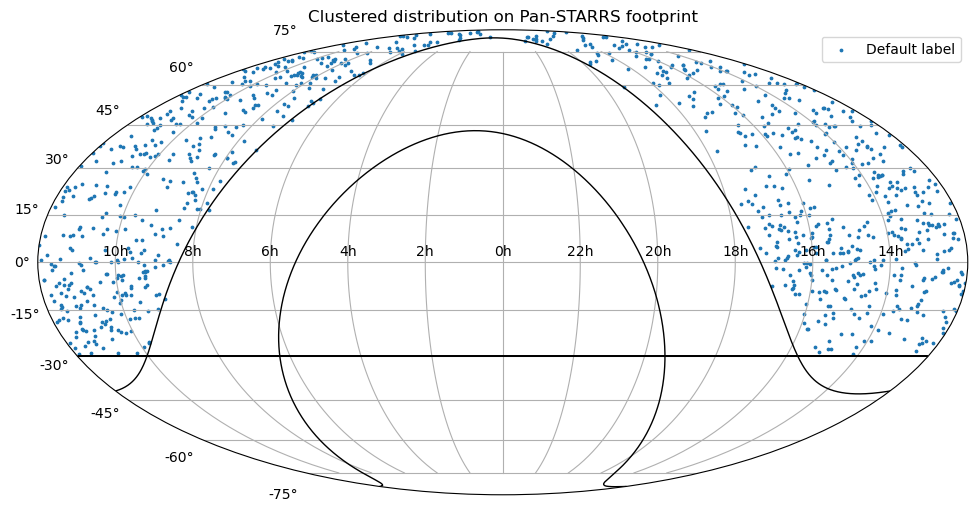

<MollweideAxes: title={'center': 'Clustered distribution on Pan-STARRS footprint'}>

In [77]:
temp_arr = make_clust_dist_ps1(1000, 1, 2)

ra_data = np.degrees(temp_arr[2])
dec_data = np.degrees(temp_arr[1])
r_data = temp_arr[0]

plot_sky_map_ps1(ra_data, dec_data, mark_size=3, labels = ['quasars'], title="Clustered distribution on Pan-STARRS footprint")

In [84]:
def make_rand_dist_ps1(num, low_r, up_r):   #Make random catalog in the PS1 footprint

    ind = np.where(np.arange(num) > -1)
    rand_ra = np.zeros(num)
    rand_dec = np.zeros(num)
    while True:
        ### using Archimede's theorem
        rand_ra[ind] = np.random.uniform(0, 360, len(ind[0]))
        rand_dec[ind] = np.degrees(np.arcsin(np.random.uniform(-0.5, 1, len(ind[0]))))
        ind = np.where((np.arcsin(np.cos(np.radians(rand_dec)) * np.cos(np.radians(27.4)) * np.cos(np.radians(rand_ra - 192.25)) \
                                            + np.sin(np.radians(rand_dec)) * np.sin(np.radians(27.4))) < np.radians(20)) | ((rand_ra > 7) & (rand_ra < 14)\
                                                & (rand_dec > 37) & (rand_dec < 43)))

        if(len(ind[0]) == 0):
            break

    r = np.random.uniform(low_r, up_r)

    x = r * np.cos(rand_dec) * np.cos(rand_ra)
    y = r * np.cos(rand_dec) * np.sin(rand_ra)
    z = r * np.sin(rand_dec)

    return rand_ra, rand_dec, r

/tmp/ipykernel_4126/1302236192.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([rand_ra, rand_dec, r])


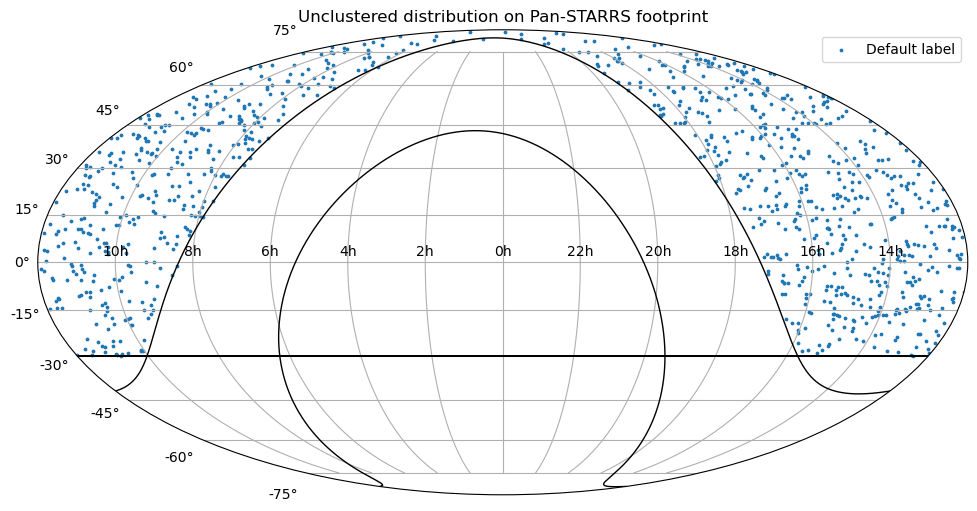

<MollweideAxes: title={'center': 'Unclustered distribution on Pan-STARRS footprint'}>

In [76]:
ra_rand, dec_rand, red_rand= make_rand_dist_ps1(1000)

plot_sky_map_ps1(ra, dec, mark_size=3, labels = ['quasars'], title="Unclustered distribution on Pan-STARRS footprint")

In [95]:
def spher_to_cart_ps1(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def Look_into_ps1(x_dat, y_dat, z_dat, r0, delta, n_d, n_r, bins, box_size, r_min, r_max):
    start = time.time()


    ra_rand, dec_rand, red_rand= make_rand_dist_ps1(n_r, low_r, up_r)
    x_ran, y_ran, z_ran = spher_to_cart_ps1(red_rand, dec_rand, ra_rand)

    ax = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax

In [96]:
global low_r, up_r
low_r = 50
up_r = 60
r_min = 10
r_max = 15

n_r = 10000
bin_start = r_min   
bin_end = r_max
bin_width = 0.01

temp_arr = make_clust_dist_ps1(1000, 1, 2)

ra_data = np.degrees(temp_arr[2])
dec_data = np.degrees(temp_arr[1])
r_data = temp_arr[0]

x_dat2, y_dat2, z_dat2 = spher_to_cart_ps1(r_data, dec_data, ra_data)

bins = np.arange(bin_start, bin_end, bin_width)
ax = Look_into_ps1(x_dat2, y_dat2, z_dat2, r0 = r0, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max)

RuntimeError: RuntimeError occurred